In [ ]:
!pip install elasticsearch

In [ ]:
import elasticsearch
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
from elasticsearch import helpers
import pandas as pd
import botocore.session

import os
import sys
import pickle
import json
import io
from skimage.io import imread
import matplotlib.pyplot as plt

In [ ]:
es = Elasticsearch([{"host":"3.12.152.249","port":"9200"}])

In [ ]:
es.ping()

False

In [ ]:
settings ={
    'settings':{
        'number_of_shards':1,
        'number_of_replicas':0
    },
    'mappings':{'dynamic':'true','_source':{'enabled':'true'},
        'properties':{
            'image_vector':{
                'type':'dense_vector',
                'dims':1792
            }
        }
    }
}

In [ ]:
es.indices.create(index='similarity-search',ignore=[400,404],body=settings)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'similarity-search'}

In [ ]:
res = es.indices.get_alias(['*'])
for name in res:
    print(name)

.apm-agent-configuration
similarity-search
.kibana-event-log-7.12.0-000001
.apm-custom-link
.tasks
.kibana_task_manager_7.12.0_001
.kibana_7.12.0_001
.ds-ilm-history-5-2021.04.14-000001


C:\Users\sdeva\anaconda3\lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: this request accesses system indices: [.apm-agent-configuration, .apm-custom-link, .tasks, .kibana_task_manager_7.12.0_001, .kibana_7.12.0_001], but in a future major version, direct access to system indices will be prevented by default
  warnings.warn(message, category=ElasticsearchWarning)


In [ ]:
#es.indices.delete(index='similarity-search',ignore=[400,404])

In [ ]:
with open(r'D:\ADM\Assignments\Assignment_3\final_data','rb') as f:
    df = pickle.load(f)

In [ ]:
df = df[df['product_id'].duplicated()]
df.index.rename('picture_id',inplace=True)
df.reset_index(inplace=True)

In [ ]:
with open(r'D:\ADM\Assignments\Assignment_3\image_vector_ELK','rb')as f:
    image_vector = pickle.load(f)

In [ ]:
df

,picture_id,category_id,product_id,picture
0,2,1000001703,2572285,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
1,5,1000001703,2695158,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
2,11,1000001703,2899743,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
3,13,1000001703,2868296,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
4,14,1000001703,2868296,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
...,...,...,...,...
14549,33248,1000021535,2720744,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14550,33249,1000021535,2720744,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14551,33251,1000021535,2594064,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14552,33252,1000021535,2594064,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...


In [ ]:
df = df[['picture_id','category_id','product_id']]

In [ ]:
image_vector_df = pd.DataFrame(pd.Series(image_vector))

In [ ]:
image_vector_df.rename(columns={0:'image_vector'},inplace=True)
image_vector_df.reset_index(inplace=True,drop=True)
df = pd.concat([df,image_vector_df],axis=1)

In [ ]:
df = df.to_dict('records')

[{'picture_id': 2,
  'category_id': 1000001703,
  'product_id': 2572285,
  'image_vector': array([0.08868098, 1.0076277 , 0.        , ..., 1.0113069 , 0.13078898,
         0.42825773], dtype=float32)},
 {'picture_id': 5,
  'category_id': 1000001703,
  'product_id': 2695158,
  'image_vector': array([0.18519479, 2.2332072 , 0.        , ..., 0.29967332, 0.        ,
         0.16150214], dtype=float32)}]

In [ ]:
def generator(df):
    for c, line in enumerate(df):
        yield{
            '_index':'similarity-search',
            '_type':'_doc',
            '_id':c,
            '_source':{
                'picture_id':line.get('picture_id',""),
                'category_id':line.get('category_id',""),
                'product_id':line.get('product_id',""),
                'image_vector':line.get('image_vector',"")
            }
        }
    raise StopIteration

In [ ]:
load = generator(df)

In [ ]:
#next(load)

{'_index': 'similarity-search',
 '_type': '_doc',
 '_id': 0,
 '_source': {'picture_id': 2,
  'category_id': 1000001703,
  'product_id': 2572285,
  'image_vector': array([0.08868098, 1.0076277 , 0.        , ..., 1.0113069 , 0.13078898,
         0.42825773], dtype=float32)}}

In [ ]:
try:
    res = helpers.bulk(es,generator(df))
except Exception as e:
    pass

In [ ]:
res

{'.apm-agent-configuration': {'aliases': {}},
 'similarity-search': {'aliases': {}},
 '.kibana-event-log-7.12.0-000001': {'aliases': {'.kibana-event-log-7.12.0': {'is_write_index': True}}},
 '.apm-custom-link': {'aliases': {}},
 '.tasks': {'aliases': {}},
 '.kibana_task_manager_7.12.0_001': {'aliases': {'.kibana_task_manager': {},
   '.kibana_task_manager_7.12.0': {}}},
 '.kibana_7.12.0_001': {'aliases': {'.kibana': {}, '.kibana_7.12.0': {}}},
 '.ds-ilm-history-5-2021.04.14-000001': {'aliases': {}}}

In [ ]:
es.indices.delete(index='similarity-search',ignore=[400,404])

{'acknowledged': True}

In [ ]:
df2 = pd.DataFrame(df)

In [ ]:
df2.drop(['image_vector'],axis=1,inplace=True)

In [ ]:
df2.drop_duplicates()

,picture_id,category_id,product_id
0,2,1000001703,2572285
1,5,1000001703,2695158
2,11,1000001703,2899743
3,13,1000001703,2868296
4,14,1000001703,2868296
...,...,...,...
14549,33248,1000021535,2720744
14550,33249,1000021535,2720744
14551,33251,1000021535,2594064
14552,33252,1000021535,2594064


In [ ]:
df[1003]

{'picture_id': 2096,
 'category_id': 1000001859,
 'product_id': 2701435,
 'image_vector': array([0.6989746, 1.6283829, 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32)}

In [ ]:
User_Query_Vector = df[1003]['image_vector']
df[1003]['picture_id']

2096

In [ ]:
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, doc['image_vector'])",
            "params": {"query_vector": User_Query_Vector}
        }
    }
}

In [ ]:
es1 = Elasticsearch()
res1 = es1.search(index='similarity-search',body={"from":0,"size": 10,"query": script_query,"_source":["picture_id"]},\
                                                  scroll="1m")

In [ ]:
res1

{'_scroll_id': 'FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnAyaXNGd2g2UjNDd2dMZ3A3ZnJzbncAAAAAAABtIBY1QjJlNWQ4VlRzaWg0LWZsZkJyLUh3',
 'took': 329,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 14500, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '1003',
    '_score': 1.0,
    '_source': {'picture_id': 2096}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '1004',
    '_score': 0.8953304,
    '_source': {'picture_id': 2097}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '401',
    '_score': 0.87465703,
    '_source': {'picture_id': 911}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '1484',
    '_score': 0.8621188,
    '_source': {'picture_id': 3186}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '259',
    '_score': 0.84447503,
    '_source': {'picture_id'

In [ ]:
scroll_id = res1['_scroll_id']
res2 = es.scroll(scroll_id=scroll_id,scroll='1m')

In [ ]:
res2

{'_scroll_id': 'FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnAyaXNGd2g2UjNDd2dMZ3A3ZnJzbncAAAAAAABtIBY1QjJlNWQ4VlRzaWg0LWZsZkJyLUh3',
 'took': 291,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 14500, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '13693',
    '_score': 0.8279558,
    '_source': {'picture_id': 31886}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '6664',
    '_score': 0.82756114,
    '_source': {'picture_id': 15485}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '10521',
    '_score': 0.82673085,
    '_source': {'picture_id': 22769}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '11476',
    '_score': 0.82586306,
    '_source': {'picture_id': 24973}},
   {'_index': 'similarity-search',
    '_type': '_doc',
    '_id': '966',
    '_score': 0.825293,
    '_source'

In [ ]:
pic_id = []
scores = []
for dic in res1['hits']['hits']:
    pic_id.append(dic['_source']['picture_id'])
    scores.append(dic['_score'])

In [ ]:
pic_id

[2096, 2097, 911, 3186, 625, 3184, 13292, 1076, 24498, 24499]

In [ ]:
with open(r'D:\ADM\Assignments\Assignment_3\fourteen_images_dict_pickle','rb')as f:
    images = pickle.load(f)

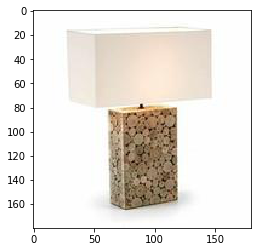

In [ ]:
plt.imshow(images[2096])

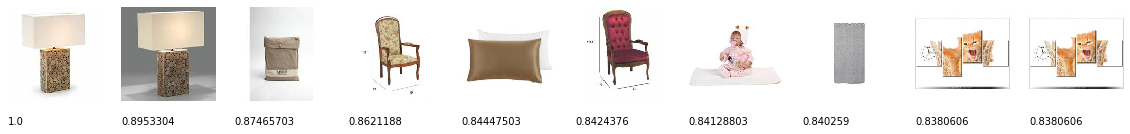

In [ ]:
f, ax = plt.subplots(1, len(pic_id), figsize=(20, 10))
for i, p_id in enumerate(pic_id):
    ax[i].imshow(images[p_id])
    ax[i].text(0,224,scores[i])
    ax[i].set_axis_off() 